In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
df = pd.read_csv("Student_Performance.csv")
df['Extracurricular Activities'].replace({
    'Yes': 1,
    'No': 0
}, inplace=True)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  int64  
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 468.9 KB


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


## Visualization

array([[<Axes: title={'center': 'Hours Studied'}>,
        <Axes: title={'center': 'Previous Scores'}>],
       [<Axes: title={'center': 'Extracurricular Activities'}>,
        <Axes: title={'center': 'Sleep Hours'}>],
       [<Axes: title={'center': 'Sample Question Papers Practiced'}>,
        <Axes: title={'center': 'Performance Index'}>]], dtype=object)

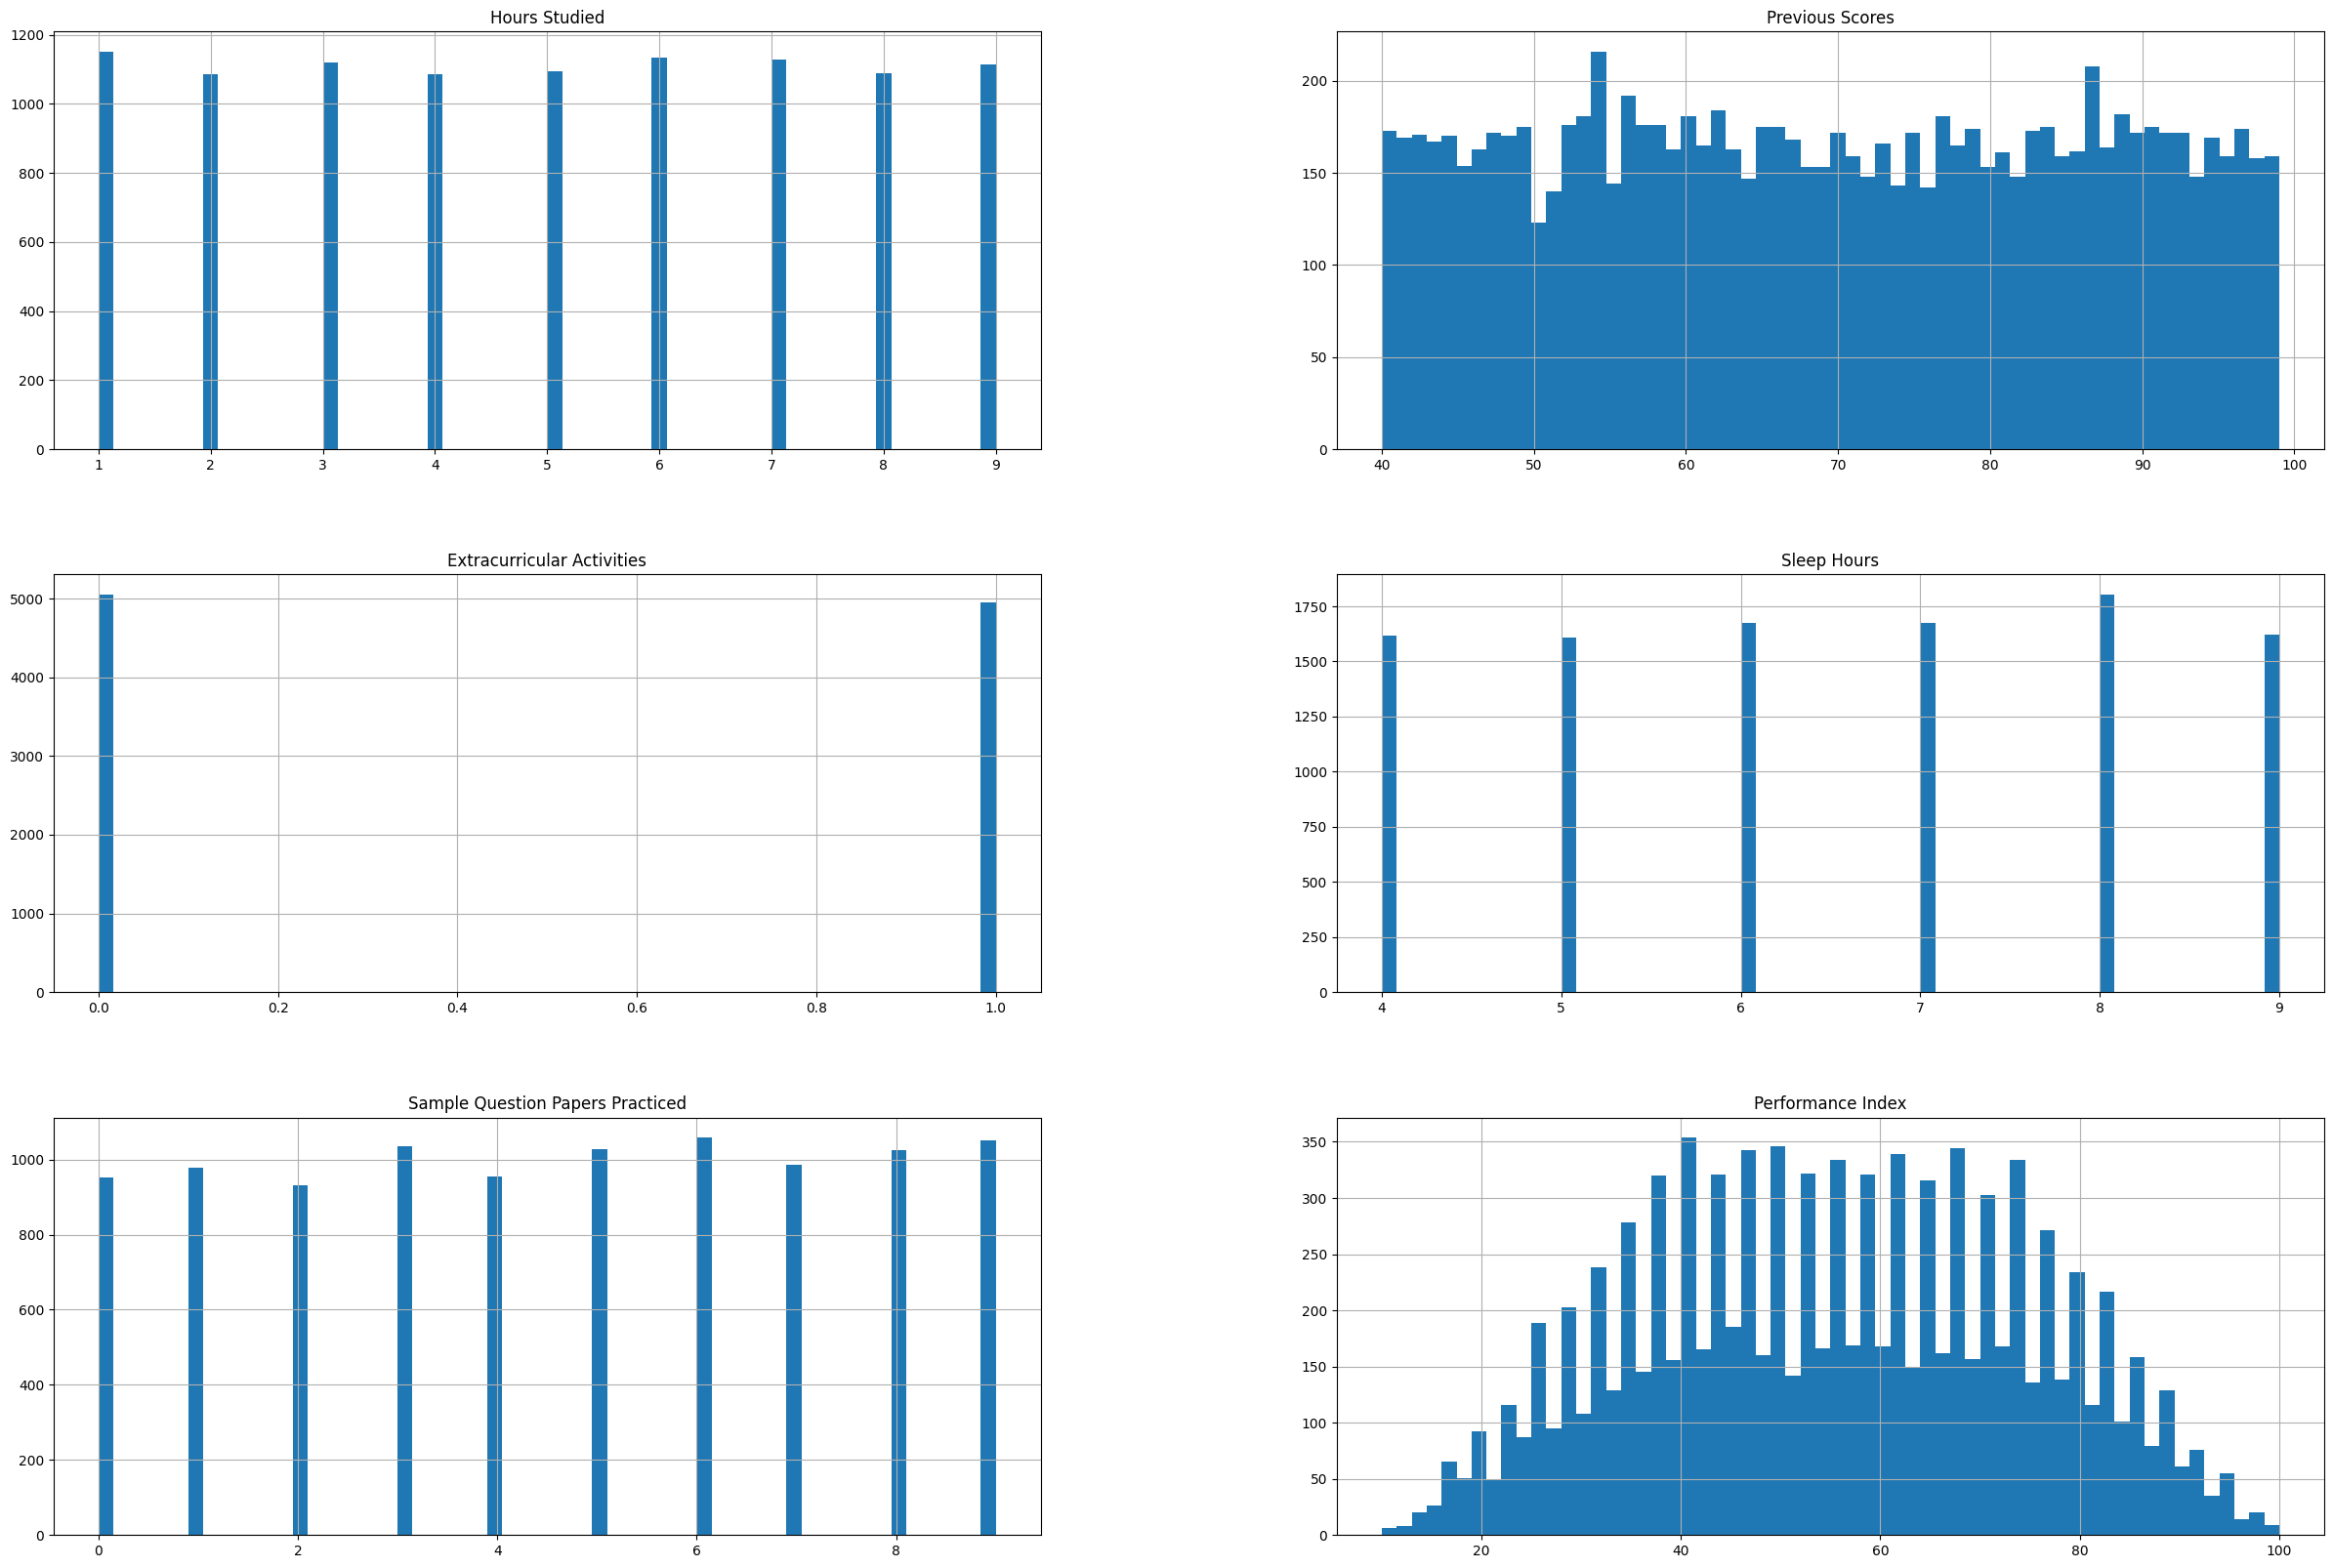

In [68]:
df.hist(bins=60, figsize=(30, 20))

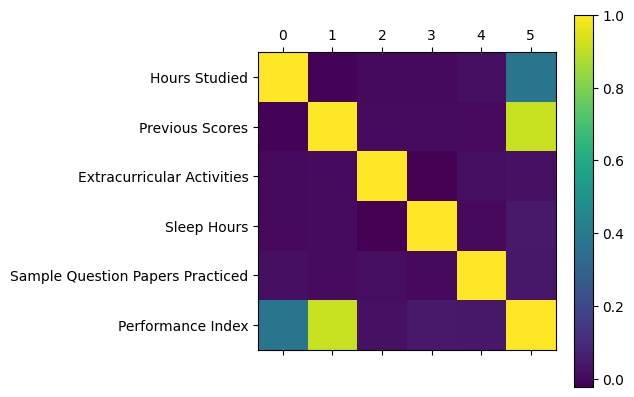

In [57]:
plt.matshow(df.corr())
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()

Здесь мы можем заметить, что выявлена корреляция целевой переменной с переменными Hours Studied и Previous Scores. Подробнее поисследуем их.

<Axes: xlabel='Hours Studied'>

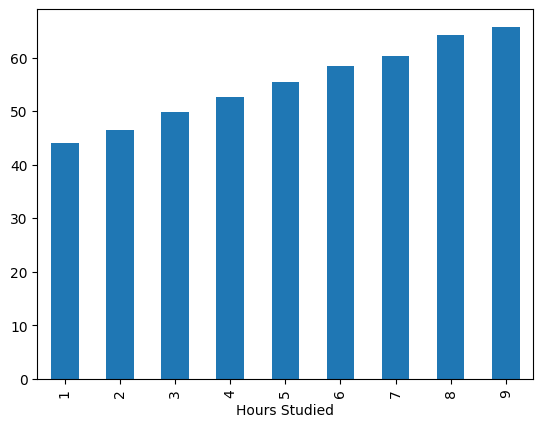

In [58]:
df.groupby('Hours Studied')['Performance Index'].mean().plot(kind='bar')

Казалось бы, что в среднем, чем больше мы учимся, тем выше баллы! Но давайте посмотрим на разброс этих данных...

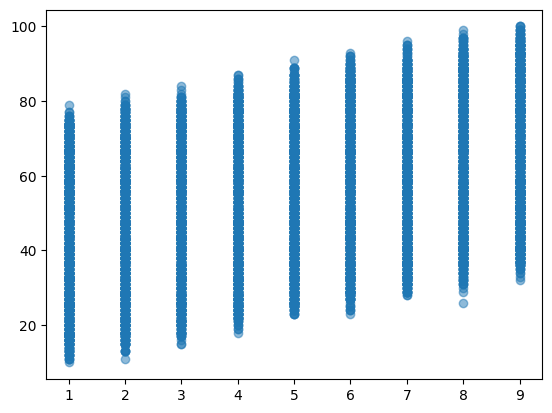

In [59]:
plt.scatter(df['Hours Studied'], df['Performance Index'], alpha=0.5)

Теперь рассмотрим второй признак, Previous Scores.

<Axes: xlabel='Previous Scores'>

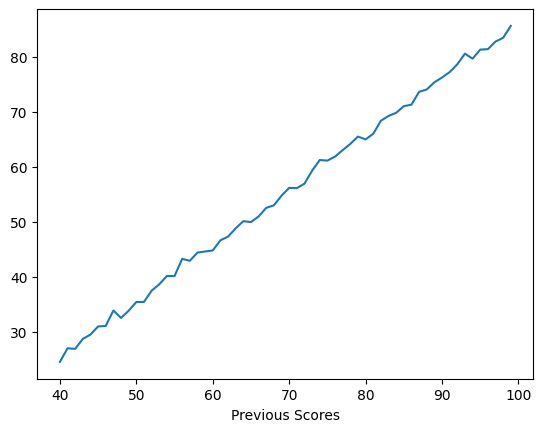

In [60]:
df.groupby('Previous Scores')['Performance Index'].mean().plot()

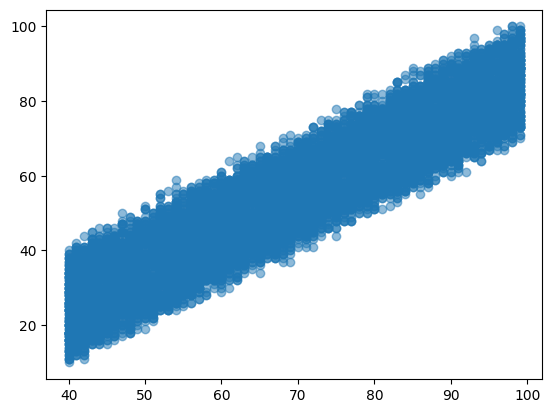

In [61]:
plt.scatter(df['Previous Scores'], df['Performance Index'], alpha=0.5)

## Train-Test split

In [62]:
train_percent = 0.6
random_state = 336771

train = df.sample(frac=train_percent, random_state=random_state)
test = df.drop(train.index)
train_x = train.drop('Performance Index', axis=1)
train_y = train['Performance Index']
test_x = test.drop('Performance Index', axis=1)
test_y = test['Performance Index']

In [63]:
class LSM:
    def __init__(self, col_names: list[str]):
        self.col_names = col_names
    
    @staticmethod
    def _prepend_ones(x):
        return np.concatenate((np.ones((len(x), 1)), x), axis=1)

    @staticmethod
    def sum_of_squares(true_y, pred_y):
        return np.sum(np.square(true_y - pred_y))

    @staticmethod
    def determination_coefficient(true_y, pred_y):
        mean_y = np.mean(true_y)
        rss = np.sum(np.square(true_y - pred_y))
        tss = np.sum(np.square(true_y - mean_y))

        return 1 - rss / tss

    def train(self, x: pd.DataFrame, y: pd.Series):
        x = LSM._prepend_ones(np.array(x[self.col_names]))
        y = np.array(y)
        self.b = np.linalg.inv((x.T @ x)) @ x.T @ y

    def pred(self, x: pd.DataFrame) -> list[float]:
        return np.array(LSM._prepend_ones(x[self.col_names])) @ self.b.T

## Модель по всем признакам

In [64]:
lsm = LSM(train_x.columns)
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.9889742150980751
Сумма квадратов: 16494.565875029828


## Модель по Hours Studied

In [65]:
lsm = LSM(['Hours Studied'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.14347438239229027
Сумма квадратов: 1281361.6761936354


## Модель по Previous Scores

In [66]:
lsm = LSM(['Previous Scores'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.8397795367381947
Сумма квадратов: 239689.6918729353


## Модель по Previous Scores и Hours Studied

In [67]:
lsm = LSM(['Hours Studied', 'Previous Scores'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.9862754166791649
Сумма квадратов: 20531.966268753167


Как мы можем заметить, что коэффициент детерминации сильно повысился за счёт Previous Scores и Hours Studied, можем сделать вывод, что результат экзамена зависит от имеющихся знаний студента, и также от того, сколько часов он потратил на учебу. А только по одному признаку определить не возможно. Если у студента хорошие знания и мало учился, то скорее у него будет немного меньше, а если хорошо подготовился, то будет примерно такой же балл. Если у студента плохие знания и много учился, то у него скорее всего сильно поднимится оценка.